# Dump visualisation
Load training dumps and visualise DINOv3 latents alongside model predictions.

Saved PCA frames to francois_notebook/video_pca_frames (count=32)


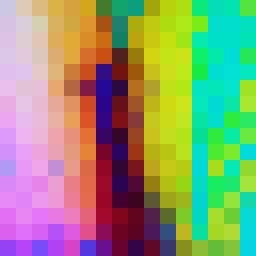

In [ ]:
from pathlib import Path
import torch
import numpy as np
from einops import rearrange
from sklearn.decomposition import PCA
import imageio.v2 as imageio
from PIL import Image
from IPython.display import Image as IPyImage, display

experiment_path = "/private/home/francoisporcher/FutureLatents/experiment/dinov3_kinetics_400_deterministic"

# --- Load dump ---
dump_root = Path(experiment_path, 'dump')
candidates = sorted(dump_root.glob('*_epoch_*'))
if len(candidates) == 0:
    raise FileNotFoundError(f"No dump samples found in {dump_root}. Run training in debug mode to generate dumps.")
sample_root = candidates[-1]

context_latents = torch.load(sample_root / 'context_latents.pt').squeeze(0)  # [D, T, H, W]
target_latents  = torch.load(sample_root / 'target_latents.pt').squeeze(0)   # [D, T, H, W]
# prediction     = torch.load(sample_root / 'prediction.pt').squeeze(0)      # optional

# --- Build feature tensor: D x T x H x W ---
video_features = torch.cat([context_latents, target_latents], dim=1)  # concat over time
D, T, H, W = video_features.shape

# --- Use (T, H, W, D) layout for easy per-frame slicing ---
feat_thwd = rearrange(video_features, "d t h w -> t h w d").contiguous()

# --- Fit PCA on all pixels across all frames ---
X_all = feat_thwd.reshape(T * H * W, D).float().cpu().numpy()
pca = PCA(n_components=3, whiten=True, random_state=0)
pca.fit(X_all)

# --- Project each frame and make RGB ---
video_pca_frames = []
for t in range(T):
    x = feat_thwd[t].reshape(H * W, D).float().cpu().numpy()  # (H*W, D)
    proj = pca.transform(x)                                   # (H*W, 3)
    rgb = torch.from_numpy(proj).view(H, W, 3)
    # Simple squashing to [0,1]; tweak the scale if too dark/bright
    rgb = torch.sigmoid(rgb * 2.0).clamp(0, 1).cpu().numpy()
    video_pca_frames.append((rgb * 255).astype(np.uint8))

# --- Save frames ---
frames_dir = Path('francois_notebook/video_pca_frames')
frames_dir.mkdir(parents=True, exist_ok=True)
for t, rgb in enumerate(video_pca_frames):
    Image.fromarray(rgb).resize((256, 256), resample=Image.NEAREST).save(frames_dir / f'frame_{t:04d}.png')
print(f"Saved PCA frames to {frames_dir} (count={len(video_pca_frames)})")

# --- Save GIF and display ---
gif_path = Path(experiment_path, 'dump', 'video_pca.gif')
imageio.mimsave(gif_path, [Image.fromarray(f).resize((256, 256), resample=Image.NEAREST) for f in video_pca_frames], fps=10)
display(IPyImage(filename=str(gif_path)))
